### Setup

In [1]:
import matplotlib
# matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import SQLAlchemy `automap` and other dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Create an engine for the `emoji.sqlite` database
#http://docs.sqlalchemy.org/en/latest/core/engines.html - echo is false so that we don't have logging.
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

## Reflect database and Query

In [4]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station

In [5]:
Measurement = Base.classes.measurement

In [6]:
# Start a session to query the database
session = Session(engine)

### Inspector

In [7]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

measurement_id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

station_id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Precipitation Analysis

In [10]:
from sqlalchemy import Date, cast
from datetime import datetime,timedelta, date #as dt
from dateutil.relativedelta import relativedelta
import matplotlib.dates as dts
#from datetime import datetime
import datetime as dt
from dateutil.relativedelta import relativedelta

In [11]:
# Latest Date, this is my vacation end date
#latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = session.query(Measurement.date).\
filter(Measurement.station == 'USC00511918').\
order_by(Measurement.date.desc()).first()
print(latest_date)

# filter(Measurement.station == 'USC00511918').\
# order_by(Measurement.date.desc()).first()

('2015-10-30',)


In [12]:
#Date 12 months ago
y = int(latest_date[0][:4])
m = int(latest_date[0][5:7])
d = int(latest_date[0][8:10])
print(y)
print(m)
print(d)
start_date = dt.date(y, m, d) - dt.timedelta(days = 365)
print(start_date)

2015
10
30
2014-10-30


In [13]:
session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).all()

[('2014-10-30', 0.05),
 ('2014-10-31', 0.02),
 ('2014-11-01', 0.04),
 ('2014-11-02', 0.0),
 ('2014-11-03', 0.0),
 ('2014-11-04', 0.0),
 ('2014-11-05', 0.14),
 ('2014-11-06', 0.1),
 ('2014-11-07', 0.0),
 ('2014-11-08', 0.09),
 ('2014-11-09', 0.0),
 ('2014-11-10', 0.0),
 ('2014-11-11', 0.0),
 ('2014-11-12', 0.05),
 ('2014-11-13', 0.0),
 ('2014-11-14', 0.0),
 ('2014-11-15', 0.62),
 ('2014-11-16', 0.01),
 ('2014-11-17', 0.0),
 ('2014-11-18', 0.0),
 ('2014-11-19', 0.0),
 ('2014-11-20', 0.08),
 ('2014-11-21', 0.0),
 ('2014-11-22', 0.0),
 ('2014-11-23', 0.0),
 ('2014-11-24', 0.04),
 ('2014-11-25', 0.0),
 ('2014-11-26', 0.0),
 ('2014-11-27', 0.0),
 ('2014-11-28', 0.0),
 ('2014-11-29', 0.0),
 ('2014-11-30', 0.01),
 ('2014-12-01', 0.0),
 ('2014-12-02', 0.02),
 ('2014-12-03', 0.15),
 ('2014-12-04', 0.09),
 ('2014-12-05', 0.0),
 ('2014-12-06', 0.0),
 ('2014-12-07', 0.0),
 ('2014-12-08', 0.0),
 ('2014-12-09', 0.0),
 ('2014-12-10', 0.0),
 ('2014-12-11', 0.05),
 ('2014-12-12', 0.01),
 ('2014-12-13', 

### Graph Precipitation Analysis

In [14]:
pastyr = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).all()

In [15]:
# create empty dict to populate
data = {'date': [], 'prcp': []}

# populate dict with rows from results
for row in pastyr:
    data['date'].append(row.date)
    data['prcp'].append(row.prcp)

#print(pastyr)
precip_df = pd.DataFrame(pastyr)
precip_df  = precip_df.set_index('date')
# create pandas df from dict
#precip_df = pd.DataFrame(data['date','prcp'], columns = ['date','prcp'], index = data['date'])

#precip_df  = precip_df.set_index('date')
precip_df.head()

,prcp
date,
2014-10-30,0.05
2014-10-31,0.02
2014-11-01,0.04
2014-11-02,0.00
2014-11-03,0.00


In [16]:
import os

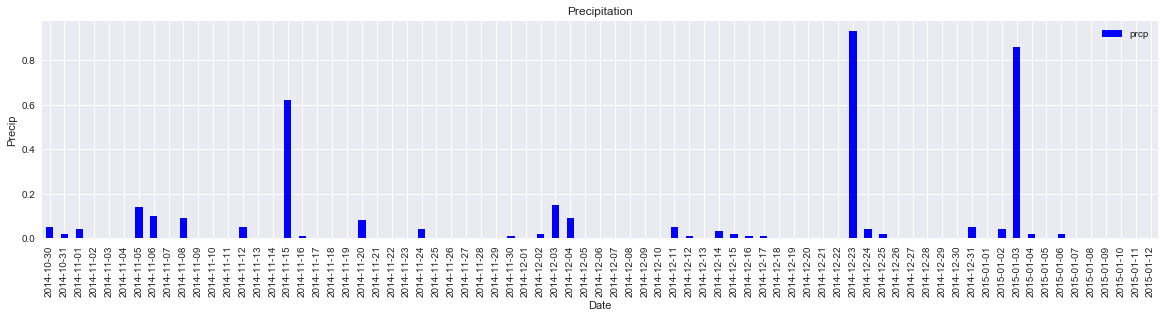

In [17]:
precip_df = precip_df.reset_index()

#For clarity plotting only 75 rows in the data frame
summary_df = precip_df.head(75)
summary_df.plot.bar(x='date', y='prcp', color=['blue'],
                                 align='center', figsize=(20, 4))


plt.title("Precipitation")
plt.xlabel("Date")
plt.ylabel("Precip")
plt.savefig(os.path.join('Images/precipitationanalysis.png'))

plt.show()

In [18]:
#Use Pandas to print the summary statistics for the precipitation data.
#precip_df.describe
precip_df['prcp'].describe()

count    5923.000000
mean        0.182352
std         0.478900
min         0.000000
25%         0.000000
50%         0.020000
75%         0.140000
max         9.640000
Name: prcp, dtype: float64

### Station Analysis

In [19]:
#Query to calculate the total number of stations
session.query(Station).count()

9

In [20]:
#print(session.query(Measurement.station).group_by(Measurement.station).all())
from sqlalchemy import func
from sqlalchemy import desc

# Design a query to find the most active stations. List the stations and observation counts in descending order
##Count the number of times each station is in the CSV. Order by descending. 

session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(desc(func.count(Measurement.station))).all()

#An alternative is below which gives the same output:
engine.execute("select station, COUNT(station) from Measurement GROUP BY station ORDER BY COUNT(station) DESC").fetchall()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [21]:
# Which station has the highest number of observations?
engine.execute("select station, COUNT(station) from Measurement GROUP BY station ORDER BY COUNT(station) DESC limit 1").fetchall()

[('USC00519281', 2772)]

In [22]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
#engine.execute("select tobs from Measurement where date(date) >= date("now", "-365 day")")
year_ago = dt.date.today() - dt.timedelta(days=365)
print(year_ago)

pastyr_tobs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date>=year_ago).all()
pastyr_tobs

2017-05-02


[('USC00519397', 78.0),
 ('USC00519397', 78.0),
 ('USC00519397', 78.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 77.0),
 ('USC00519397', 78.0),
 ('USC00519397', 78.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 77.0),
 ('USC00519397', 78.0),
 ('USC00519397', 78.0),
 ('USC00519397', 78.0),
 ('USC00519397', 73.0),
 ('USC00519397', 76.0),
 ('USC00519397', 78.0),
 ('USC00519397', 76.0),
 ('USC00519397', 77.0),
 ('USC00519397', 87.0),
 ('USC00519397', 77.0),
 ('USC00519397', 77.0),
 ('USC00519397', 74.0),
 ('USC00519397', 76.0),
 ('USC00519397', 75.0),
 ('USC00519397', 76.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 80.0),
 ('USC00519397', 79.0),
 ('USC00519397', 79.0),
 ('USC00519397', 80.0),
 ('USC00519397', 80.0),
 ('USC00519397', 77.0),
 ('USC00519397', 79.0),
 ('USC00519397', 83.0),
 ('USC00519397', 80.0),
 ('USC00519397',

In [23]:
# Filter by the station with the highest number of observations.
##USC00519281 was the station with the highest number of observations, which was shown in the output above. 
highest_tobs = session.query(Measurement.tobs).filter(Measurement.date>=year_ago).filter(Measurement.station=="USC00519281").all()
highest_tobs
## Find thos players from the USA who were born after 1989
# born_after_ninties = session.query(BaseballPlayer).\
#     filter(BaseballPlayer.birth_year > 1989).filter(BaseballPlayer.birth_country == "USA").\
#     count()

[(75.0),
 (70.0),
 (75.0),
 (70.0),
 (79.0),
 (75.0),
 (70.0),
 (67.0),
 (74.0),
 (70.0),
 (75.0),
 (76.0),
 (77.0),
 (74.0),
 (74.0),
 (74.0),
 (69.0),
 (68.0),
 (76.0),
 (74.0),
 (71.0),
 (71.0),
 (74.0),
 (74.0),
 (74.0),
 (74.0),
 (80.0),
 (74.0),
 (72.0),
 (75.0),
 (80.0),
 (76.0),
 (76.0),
 (77.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (72.0),
 (74.0),
 (74.0),
 (74.0),
 (76.0),
 (74.0),
 (75.0),
 (73.0),
 (79.0),
 (75.0),
 (72.0),
 (72.0),
 (74.0),
 (72.0),
 (72.0),
 (77.0),
 (71.0),
 (73.0),
 (76.0),
 (77.0),
 (76.0),
 (76.0),
 (79.0),
 (81.0),
 (76.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (78.0),
 (78.0),
 (69.0),
 (72.0),
 (74.0),
 (74.0),
 (76.0),
 (80.0),
 (80.0),
 (76.0),
 (76.0),
 (76.0),
 (77.0),
 (77.0),
 (77.0),
 (82.0),
 (75.0),
 (77.0),
 (75.0),
 (76.0),
 (81.0),
 (82.0),
 (81.0),
 (76.0),
 (77.0),
 (82.0),
 (83.0),
 (77.0),
 (77.0),
 (77.0),
 (76.0),
 (76.0),
 (79.0)]

In [24]:
# Plot the results as a histogram with bins=12.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

##First, add the results from highest_tobs into a Pandas dataframe to plot.
columns = ['tobs']
tobs_df = pd.DataFrame([x for x in highest_tobs], columns=columns)
##Reset index since the output above gives a sequential ID and tobs values.
tobs_df = tobs_df.set_index('tobs')
tobs_df.head(5)

""
tobs
75.0
70.0
75.0
70.0
79.0


In [25]:
tobs_df = tobs_df.reset_index()

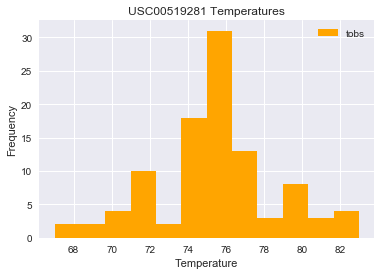

In [26]:
##Use matplot lib for plotting a histogram from the dataframe.
#tobs_df = tobs_df.reset_index()
#df.plt.hist(bins =20, color=['gold'])
#kind = 'hist'
tobs_df.plot.hist(bins =12, color=['orange'])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'])
## plt.xticks(range(0, 7))
## plt.yticks(range(1, 20))
plt.title('USC00519281 Temperatures')
plt.show()

### Temperature Analysis

In [27]:
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and 
##return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date,end_date):
    
    return session.query(func.avg(Measurement.tobs), func.min(Measurement.tobs), func.max(Measurement.tobs)).\
           filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
print(calc_temps('2017-01-15', '2017-01-30'))

[(70.55681818181819, 63.0, 80.0)]


In [28]:
import datetime as datetime
trip_arrive = datetime.date(2018, 4, 20)
trip_leave = datetime.date(2018, 4, 27)
last_year = datetime.timedelta(days = 365)
temp_avg_1st_year = calc_temps((trip_arrive - last_year), (trip_leave - last_year))
print(temp_avg_1st_year)

[(74.4186046511628, 68.0, 81.0)]


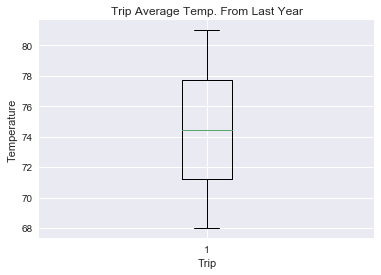

In [29]:
fig, ax = plt.subplots()
x = range(len(temp_avg_1st_year))
ax.boxplot(temp_avg_1st_year)
ax.set_title("Trip Average Temp. From Last Year")
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")

plt.show()

### Flask Setup

In [30]:
from flask import Flask, jsonify

In [31]:
climate_analysis_app = Flask(__name__)

In [32]:
app = Flask(__name__)

### Function

In [33]:
def calc_tempsOnlyOneDate(d1):
    sel = [func.avg(Measurement.tobs),
          func.min(Measurement.tobs),
          func.max(Measurement.tobs)]
    
    calcone_summary = session.query(*sel).filter(func.strftime(Measurement.date)>d1).all()
    
    return calcone_summary

#call the function
calc_tempsOnlyOneDate('2017-01-02')

[(74.06205250596659, 58.0, 87.0)]

### Flask Routes

In [ ]:
@climate_analysis_app.route("/")
def welcome():
  print("Climate Analaysis Home Page")
  return (
      f"Available Routes:<br/>"
      f"/api/v1.0/precipitation<br/>"
      f"/api/v1.0/stations<br/>"
      f"/api/v1.0/tobs<br/>"
      f"/api/v1.0/startend<br/>"
      f"/api/v1.0/start"
  )


@climate_analysis_app.route("/api/v1.0/precipitation")
def precipitation():
  #results = session.query(Measurement).all()
  results = session.query(Measurement.date, Measurement.prcp).\
  filter(Measurement.date >= year_ago).all()

  # Create a dictionary from the row data and append to a list of all_passengers
  all_measurement = []
  for measurement in results:
      measurement_dict = {}
      measurement_dict["date"] = measurement.date
      measurement_dict["prcp"] = measurement.prcp
     
      all_measurement.append(measurement_dict)

  return jsonify(all_measurement)

@climate_analysis_app.route("/api/v1.0/stations")
def stationnames():
  """Return a list of all passenger names"""
  # Query all Stations
  results = session.query(Station.name).all()

  # Convert list of tuples into normal list
  all_names = list(np.ravel(results))

  return jsonify(all_names)

@climate_analysis_app.route("/api/v1.0/tobs")
def tempobservations():
  """Return a list of all passenger names"""
  # Query all Stations
  results = session.query(Measurement.tobs).\
  filter(Measurement.date >= year_ago).all()

  # Convert list of tuples into normal list
  all_tobs = list(np.ravel(results))

  return jsonify(all_tobs)



@climate_analysis_app.route("/api/v1.0/startend")
def tempstartend():

 results = calc_temps('2017-01-01', '2017-01-15')
 #print(results)
 all_tempstartend = list(np.ravel(results))

 return jsonify(all_tempstartend)


@climate_analysis_app.route("/api/v1.0/start")
def tempstart():

 results = calc_tempsOnlyOneDate('2017-01-01')
 #print(results)
 all_tempstart = list(np.ravel(results))

 return jsonify(all_tempstart)

if __name__ == '__main__':
  climate_analysis_app.run(debug=False)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [02/May/2018 21:31:46] "GET / HTTP/1.1" 200 -


Climate Analaysis Home Page


127.0.0.1 - - [02/May/2018 21:31:53] "GET /api/v1.0/start HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:32:02] "GET /api/v1.0/startend HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:32:19] "GET /api/v1.0/tobs HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:32:55] "GET /api/v1.0/precipitation HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:33:16] "GET /api/v1.0/stations HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:33:29] "GET /api/v1.0/tobs HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:33:46] "GET /api/v1.0/startend HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:33:52] "GET /api/v1.0/start HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:42:51] "GET /api/v1.0/precipitation HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:44:18] "GET /api/v1.0/stations HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:45:16] "GET /api/v1.0/tobs HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:46:25] "GET /api/v1.0/startend HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2018 21:47:54] "GET /api/v1.0/start HTTP/1.1" 200 -
